In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import json

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_ind=[]
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    refined=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])


        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_ind.append(adap.PoissonEstimator(MP,uh,f))
            err_est[iter] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_ind, refined

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
            
        if iter < maxiter-1:
            start=time.time()
            M.refine()
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0.

0


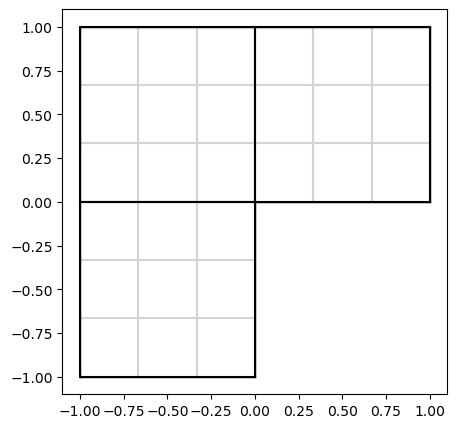

Refinement took 0.00015687942504882812 seconds.
1


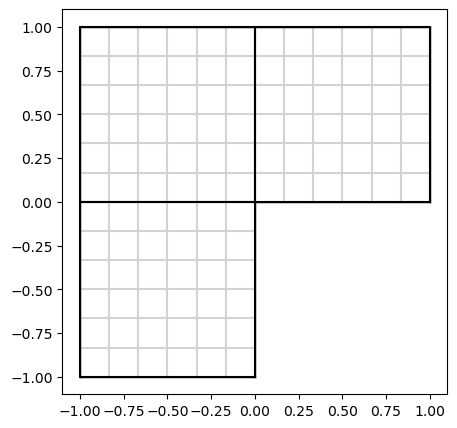

Refinement took 0.00015783309936523438 seconds.
2


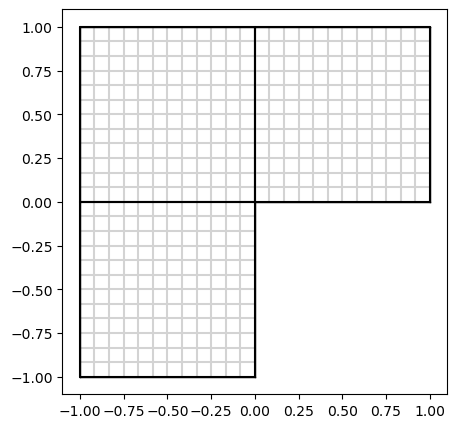

Refinement took 0.0001628398895263672 seconds.
3


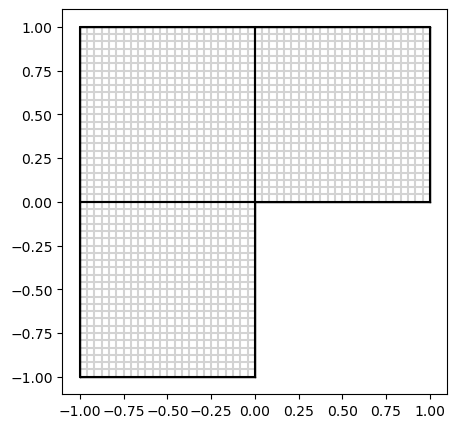

Refinement took 0.000164031982421875 seconds.
4


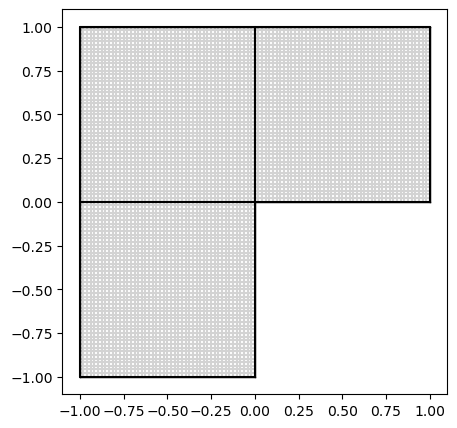

Refinement took 0.00019502639770507812 seconds.
5


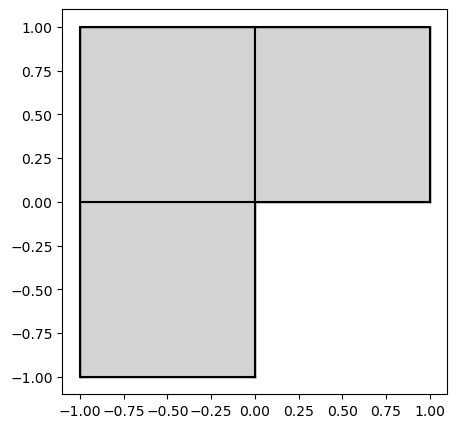

Refinement took 0.000240325927734375 seconds.
6


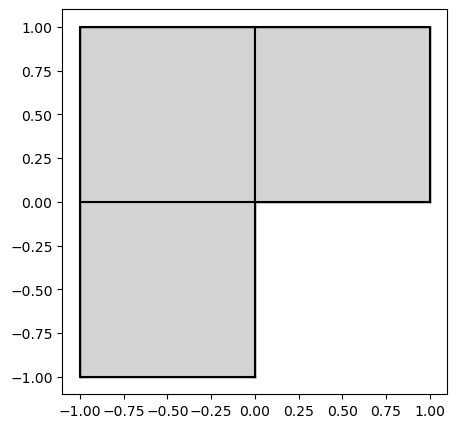

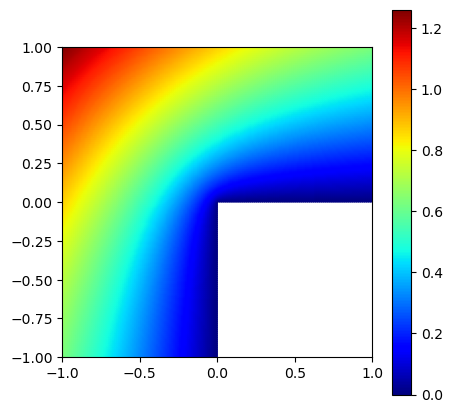

In [7]:
deg=2
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=True)
# M.draw()

0


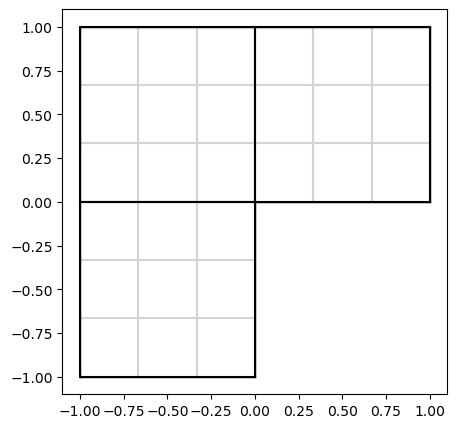

Residual contributions took 0.03338432312011719 seconds.
Jump contributions took 0.01318359375 seconds.
Estimate and Marking took 0.046715497970581055 seconds.
Refinement took 0.008701562881469727 seconds.
1


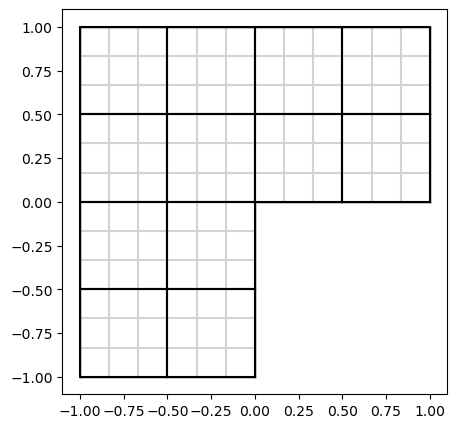

Residual contributions took 0.07474660873413086 seconds.
Jump contributions took 0.08637285232543945 seconds.
Estimate and Marking took 0.16127562522888184 seconds.
Refinement took 0.010744810104370117 seconds.
2


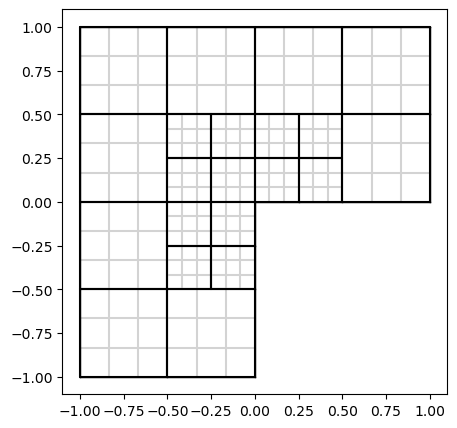

Residual contributions took 0.13064837455749512 seconds.
Jump contributions took 0.20886874198913574 seconds.
Estimate and Marking took 0.3396754264831543 seconds.
Refinement took 0.01260232925415039 seconds.
3


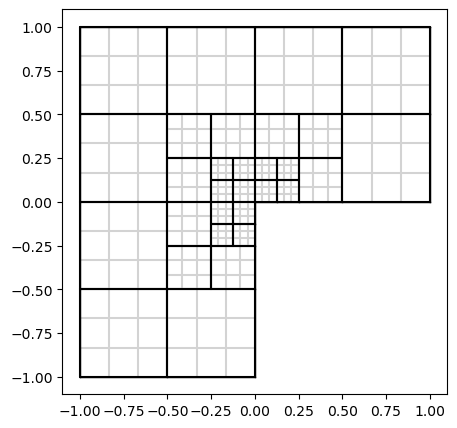

Residual contributions took 0.18541455268859863 seconds.
Jump contributions took 0.3183410167694092 seconds.
Estimate and Marking took 0.5042533874511719 seconds.
Refinement took 0.014564990997314453 seconds.
4


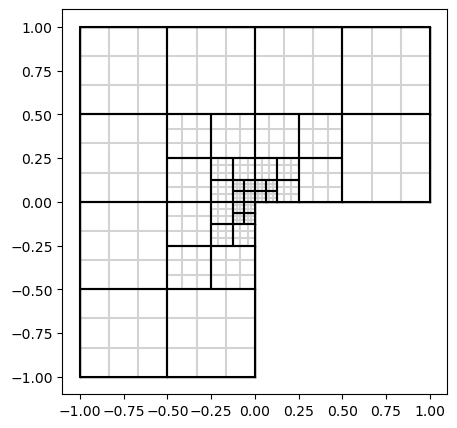

Residual contributions took 0.24079322814941406 seconds.
Jump contributions took 0.43332791328430176 seconds.
Estimate and Marking took 0.6745152473449707 seconds.
Refinement took 0.01653599739074707 seconds.
5


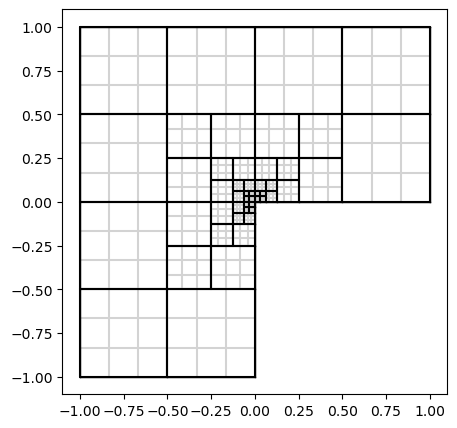

Residual contributions took 0.2944955825805664 seconds.
Jump contributions took 0.50933837890625 seconds.
Estimate and Marking took 0.8042235374450684 seconds.
Refinement took 0.018407344818115234 seconds.
6


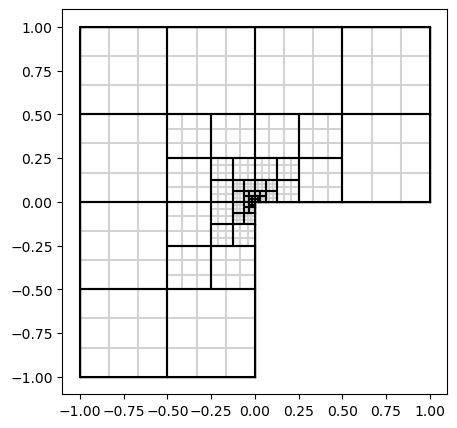

Residual contributions took 0.3520686626434326 seconds.
Jump contributions took 0.6202614307403564 seconds.
Estimate and Marking took 0.9725723266601562 seconds.
Refinement took 0.02073049545288086 seconds.
7


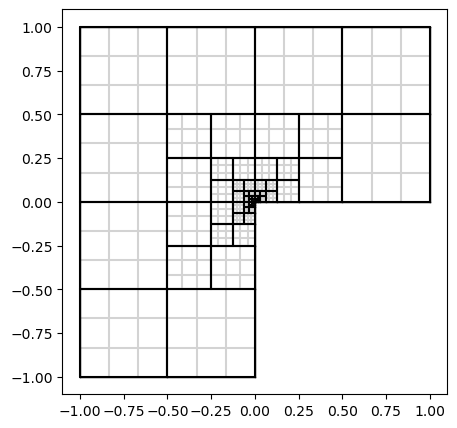

Residual contributions took 0.40399670600891113 seconds.
Jump contributions took 0.7251417636871338 seconds.
Estimate and Marking took 1.129683256149292 seconds.
Refinement took 0.022254467010498047 seconds.
8


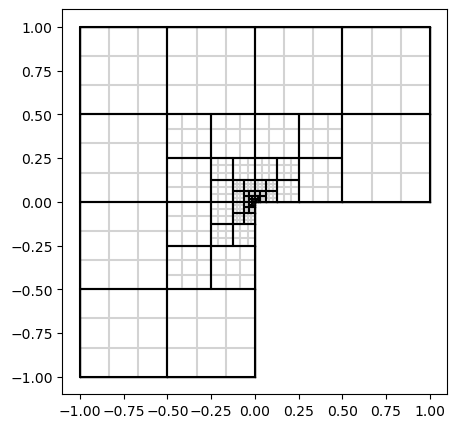

Residual contributions took 0.4616830348968506 seconds.
Jump contributions took 0.8301677703857422 seconds.
Estimate and Marking took 1.2924039363861084 seconds.
Refinement took 0.024254798889160156 seconds.
9


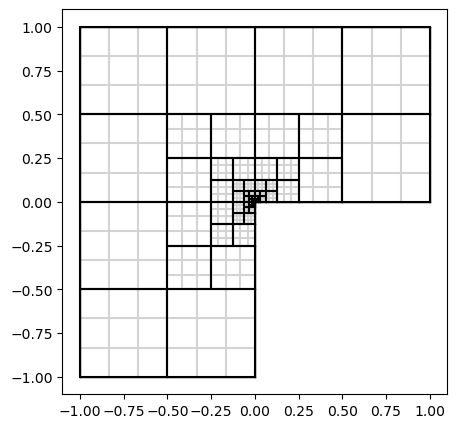

Residual contributions took 0.5150761604309082 seconds.
Jump contributions took 0.9956519603729248 seconds.
Estimate and Marking took 1.5113003253936768 seconds.
Refinement took 0.05388951301574707 seconds.
10


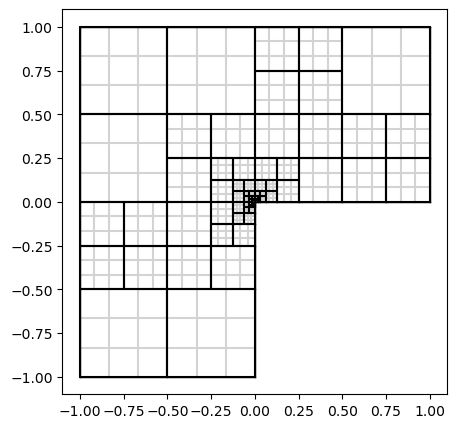

Residual contributions took 0.6261272430419922 seconds.
Jump contributions took 1.1310508251190186 seconds.
Estimate and Marking took 1.7577776908874512 seconds.
Refinement took 0.1288895606994629 seconds.
11


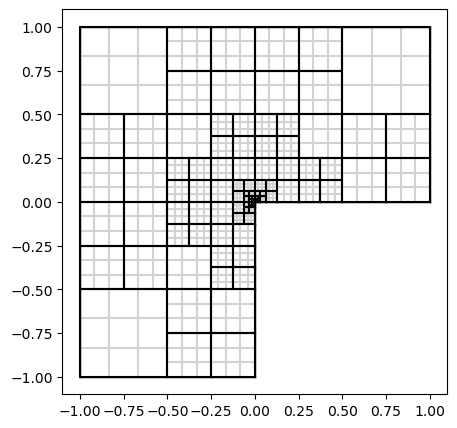

Residual contributions took 0.8474993705749512 seconds.
Jump contributions took 1.51999831199646 seconds.
Estimate and Marking took 2.368112564086914 seconds.
Refinement took 0.19964194297790527 seconds.
12


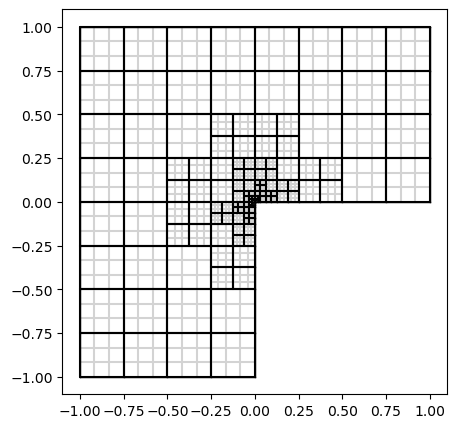

Residual contributions took 1.144416332244873 seconds.
Jump contributions took 1.994499921798706 seconds.
Estimate and Marking took 3.139594793319702 seconds.
Refinement took 0.3119833469390869 seconds.
13


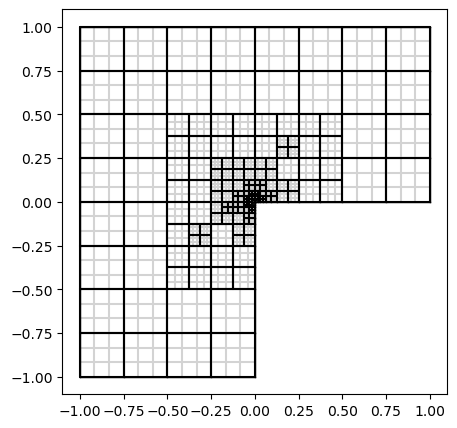

Residual contributions took 1.4646005630493164 seconds.
Jump contributions took 2.6408121585845947 seconds.
Estimate and Marking took 4.106164216995239 seconds.
Refinement took 0.6663858890533447 seconds.
14


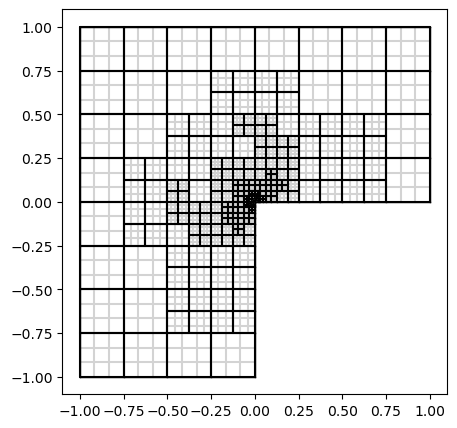

Residual contributions took 2.02018141746521 seconds.
Jump contributions took 3.7418932914733887 seconds.
Estimate and Marking took 5.762985944747925 seconds.
Refinement took 1.4605684280395508 seconds.
15


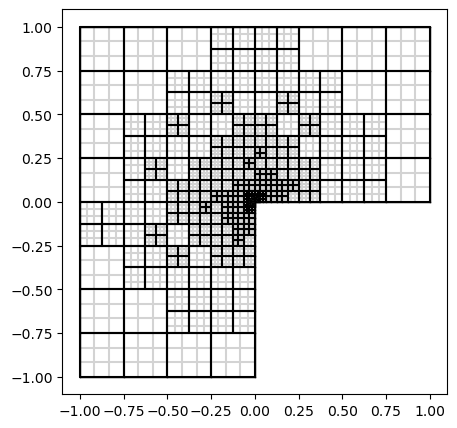

Residual contributions took 2.970270872116089 seconds.
Jump contributions took 5.475254535675049 seconds.
Estimate and Marking took 8.44663119316101 seconds.
Refinement took 2.8523149490356445 seconds.
16


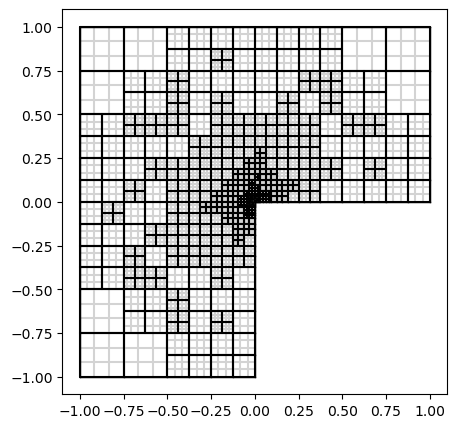

Residual contributions took 4.307806491851807 seconds.
Jump contributions took 7.9270195960998535 seconds.
Estimate and Marking took 12.23621678352356 seconds.
Refinement took 5.428030729293823 seconds.
17


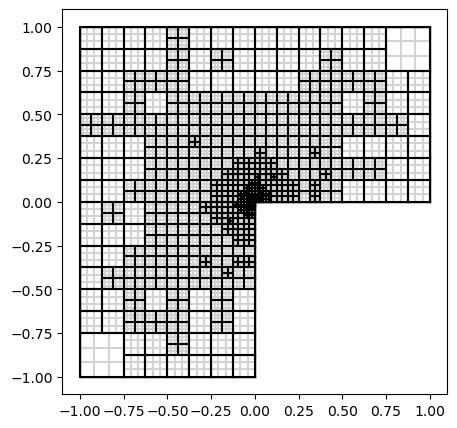

Residual contributions took 6.189772844314575 seconds.
Jump contributions took 11.277011156082153 seconds.
Estimate and Marking took 17.46865153312683 seconds.
Refinement took 10.723484516143799 seconds.
18


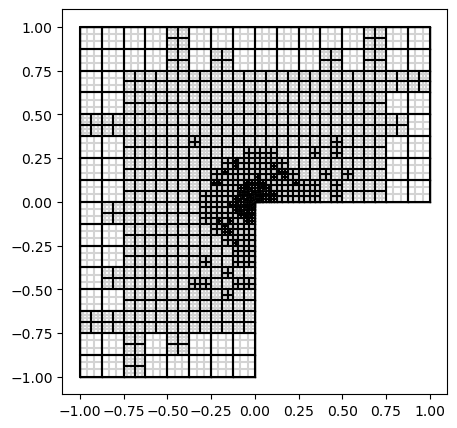

Residual contributions took 8.942774772644043 seconds.
Jump contributions took 16.32265567779541 seconds.
Estimate and Marking took 25.268179655075073 seconds.
Refinement took 21.52922224998474 seconds.
19


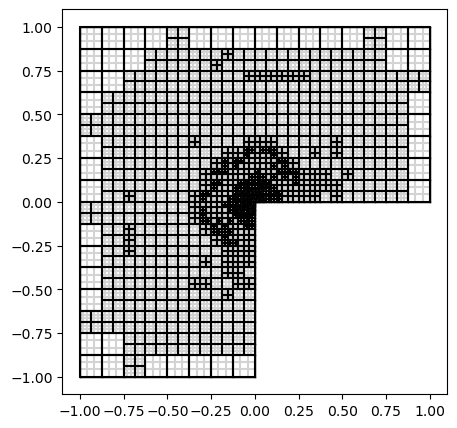

Residual contributions took 12.932445049285889 seconds.
Jump contributions took 23.211734533309937 seconds.
Estimate and Marking took 36.14876961708069 seconds.
Refinement took 45.19684147834778 seconds.
20


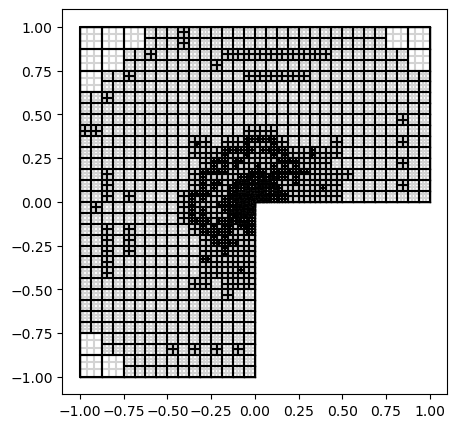

Residual contributions took 18.092754364013672 seconds.
Jump contributions took 34.08892583847046 seconds.
Estimate and Marking took 52.18833351135254 seconds.
Refinement took 82.94665050506592 seconds.
21


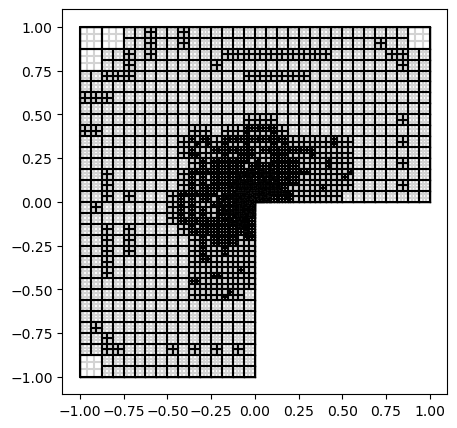

Residual contributions took 24.66230082511902 seconds.
Jump contributions took 46.96553087234497 seconds.
Estimate and Marking took 71.63844060897827 seconds.
Refinement took 155.7583658695221 seconds.
22


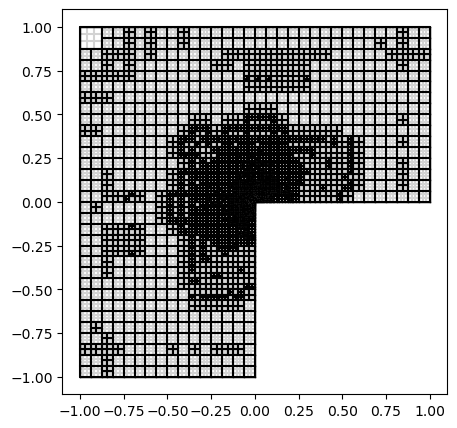

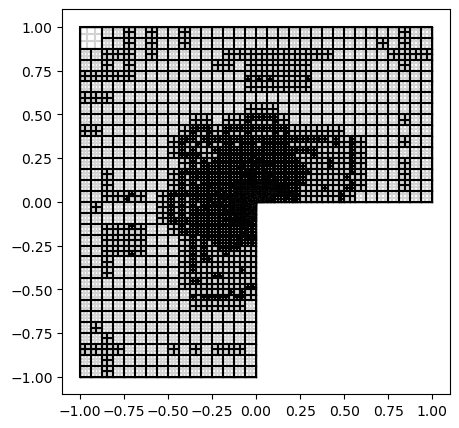

In [8]:
deg=2
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=23, theta=0.9)
M.draw()

In [9]:
np.savetxt('Lp2n3.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

In [17]:
np.log(H1err_a[1:]/H1err_a[:-1])/np.log(numdofs_a[:-1]/numdofs_a[1:])

array([0.37782, 0.98226, 1.44667, 1.90655, 2.35852, 2.78912, 3.16193, 3.39042, 3.31512, 1.81137, 1.57942, 1.64682, 1.58561, 1.24431, 1.13355, 1.17815, 1.30432, 1.25961, 1.07131, 1.1554 , 1.10773, 1.0535 ])

In [18]:
np.log(L2err_a[1:]/L2err_a[:-1])/np.log(numdofs_a[:-1]/numdofs_a[1:])

array([0.78109, 2.01374, 2.93921, 3.8188 , 4.48854, 4.20955, 2.3132 , 0.69368, 0.16641, 1.51142, 2.66011, 3.60948, 1.13203, 1.31424, 0.81181, 1.50499, 1.99949, 2.82289, 0.77077, 2.1439 , 0.89518, 1.07524])

In [ ]:
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp2n3.txt').reshape((4,23))

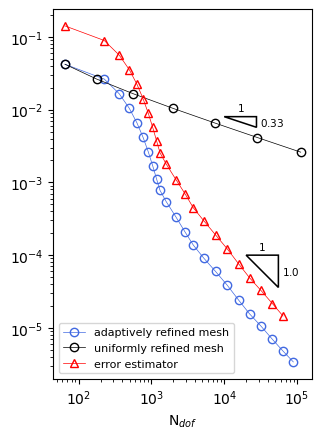

In [48]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(3/2) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 8})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(2*1e4,1e-4),2, deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.8*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

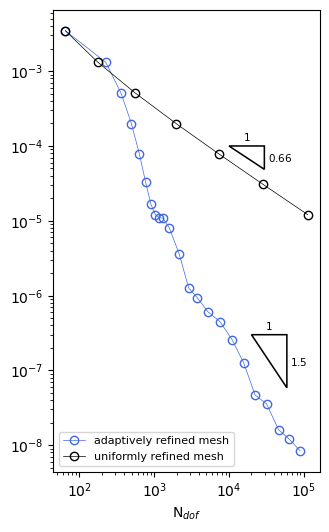

In [68]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 8})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(2*1e4,3*1e-7),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.1*1e-3),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

0
Refinement took 0.00016951560974121094 seconds.
1
Refinement took 0.00017142295837402344 seconds.
2
Refinement took 0.00016498565673828125 seconds.
3
Refinement took 0.00033211708068847656 seconds.
4
Refinement took 0.00021767616271972656 seconds.
5
Refinement took 0.0002551078796386719 seconds.
6
Refinement took 0.00029397010803222656 seconds.
7


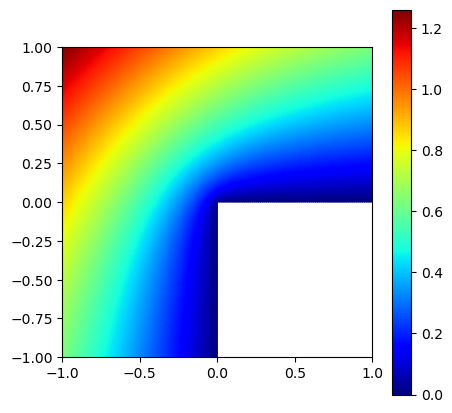

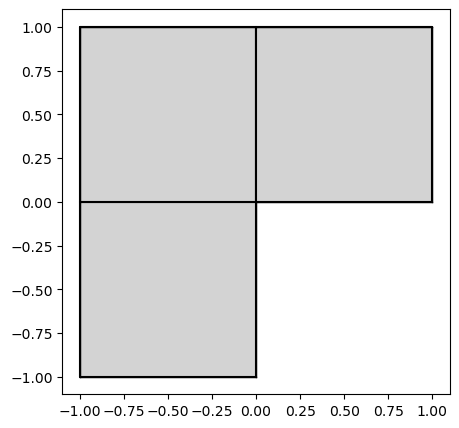

In [10]:
deg=3
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=8, draw=False)
M.draw()

0


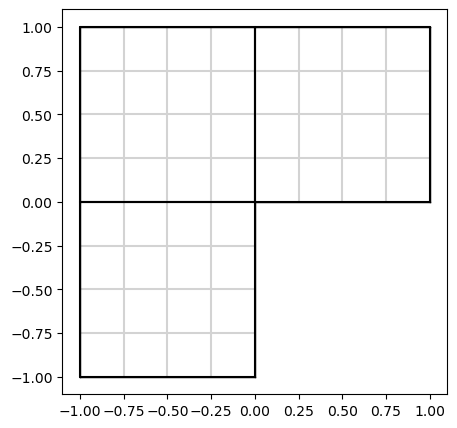

Residual contributions took 0.019057750701904297 seconds.
Jump contributions took 0.010324239730834961 seconds.
Estimate and Marking took 0.029541969299316406 seconds.
Refinement took 0.005535125732421875 seconds.
1


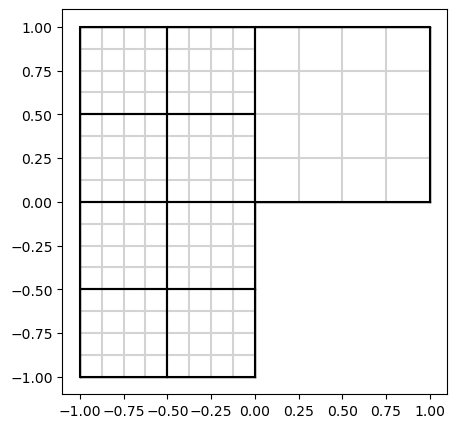

Residual contributions took 0.05717110633850098 seconds.
Jump contributions took 0.0649266242980957 seconds.
Estimate and Marking took 0.12226343154907227 seconds.
Refinement took 0.006444692611694336 seconds.
2


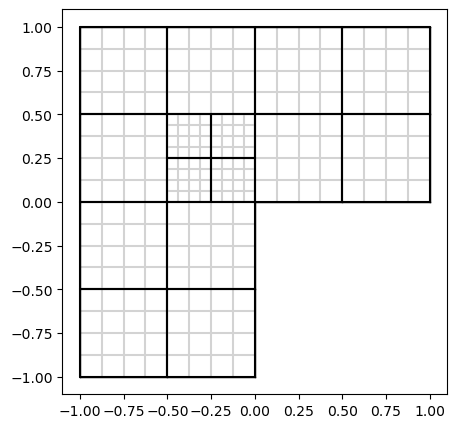

Residual contributions took 0.09472417831420898 seconds.
Jump contributions took 0.12863492965698242 seconds.
Estimate and Marking took 0.223557710647583 seconds.
Refinement took 0.011334896087646484 seconds.
3


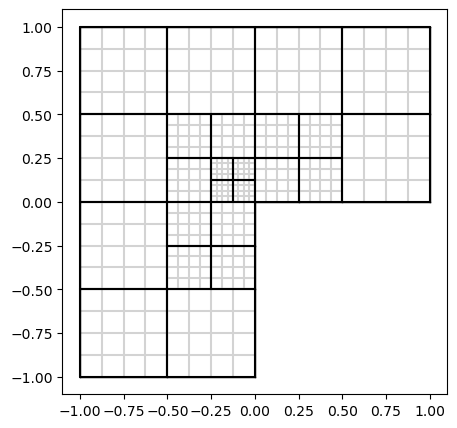

Residual contributions took 0.15137100219726562 seconds.
Jump contributions took 0.2363295555114746 seconds.
Estimate and Marking took 0.38831329345703125 seconds.
Refinement took 0.01354360580444336 seconds.
4


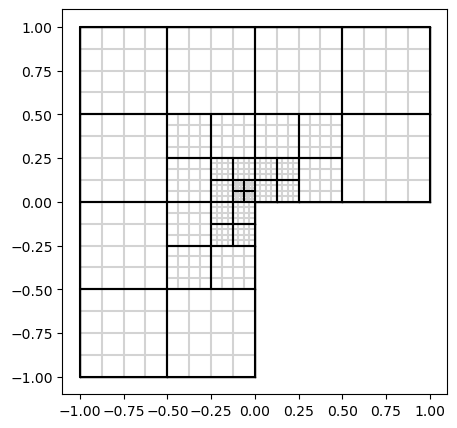

Residual contributions took 0.2073981761932373 seconds.
Jump contributions took 0.3421199321746826 seconds.
Estimate and Marking took 0.5497667789459229 seconds.
Refinement took 0.015320777893066406 seconds.
5


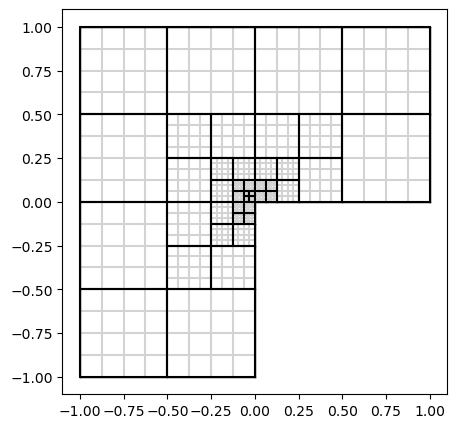

Residual contributions took 0.26323699951171875 seconds.
Jump contributions took 0.4442172050476074 seconds.
Estimate and Marking took 0.7076966762542725 seconds.
Refinement took 0.01735091209411621 seconds.
6


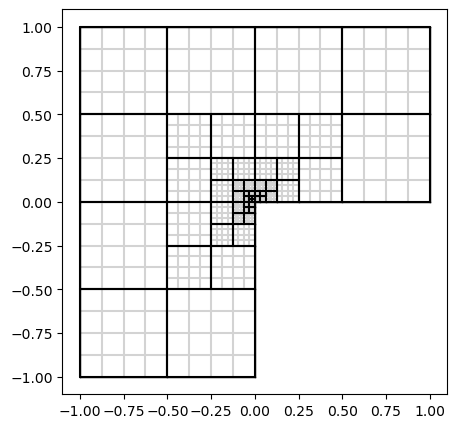

Residual contributions took 0.3201916217803955 seconds.
Jump contributions took 0.5525290966033936 seconds.
Estimate and Marking took 0.8729691505432129 seconds.
Refinement took 0.019736528396606445 seconds.
7


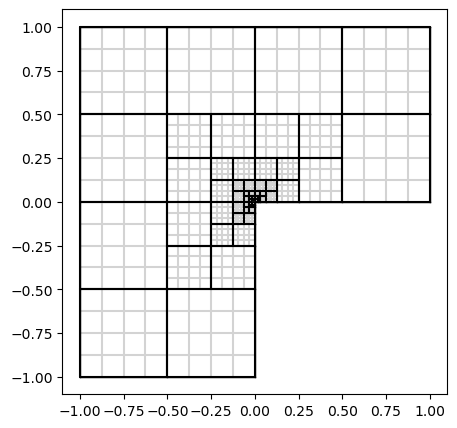

Residual contributions took 0.3717825412750244 seconds.
Jump contributions took 0.6535811424255371 seconds.
Estimate and Marking took 1.0259120464324951 seconds.
Refinement took 0.02091073989868164 seconds.
8


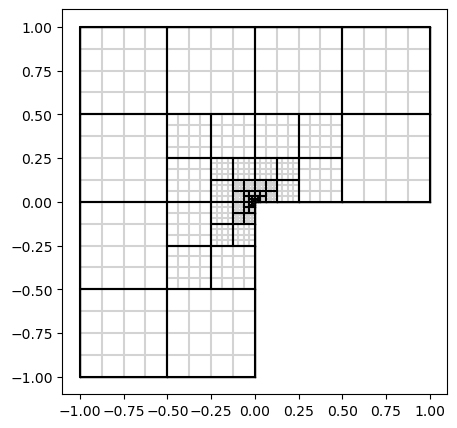

Residual contributions took 0.41847681999206543 seconds.
Jump contributions took 0.768700122833252 seconds.
Estimate and Marking took 1.1877403259277344 seconds.
Refinement took 0.023137331008911133 seconds.
9


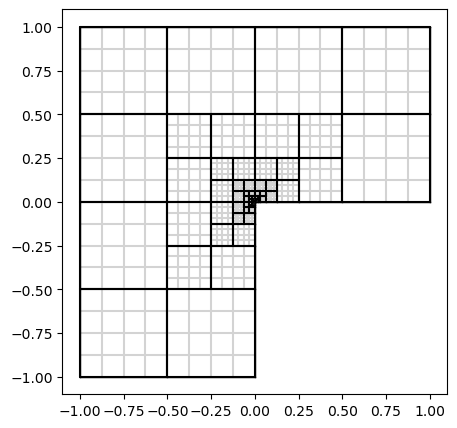

Residual contributions took 0.48314738273620605 seconds.
Jump contributions took 0.8685324192047119 seconds.
Estimate and Marking took 1.351949691772461 seconds.
Refinement took 0.025228261947631836 seconds.
10


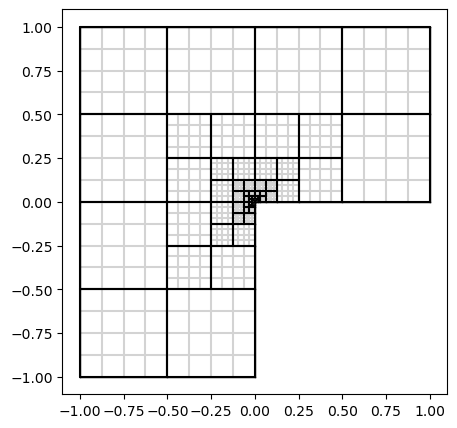

Residual contributions took 0.5425682067871094 seconds.
Jump contributions took 0.990290641784668 seconds.
Estimate and Marking took 1.5331685543060303 seconds.
Refinement took 0.026912689208984375 seconds.
11


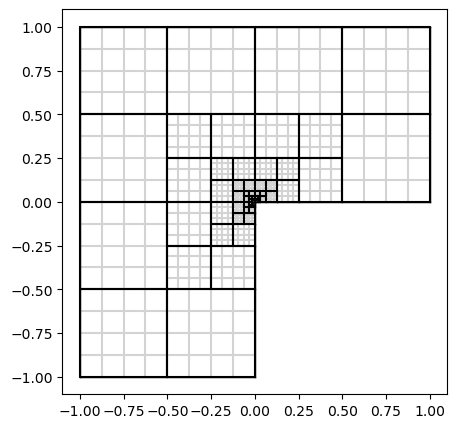

Residual contributions took 0.5940670967102051 seconds.
Jump contributions took 1.205138921737671 seconds.
Estimate and Marking took 1.7996597290039062 seconds.
Refinement took 0.030321359634399414 seconds.
12


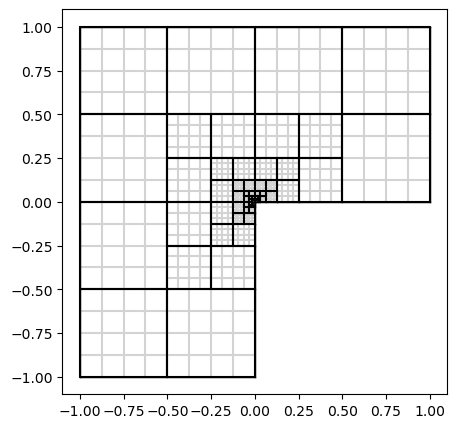

Residual contributions took 0.6527466773986816 seconds.
Jump contributions took 1.1910645961761475 seconds.
Estimate and Marking took 1.8443830013275146 seconds.
Refinement took 0.05296182632446289 seconds.
13


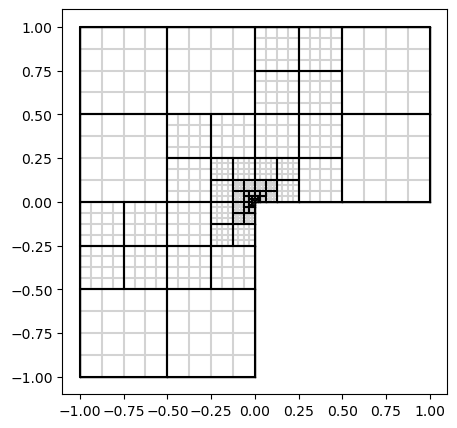

Residual contributions took 0.7386515140533447 seconds.
Jump contributions took 1.3680946826934814 seconds.
Estimate and Marking took 2.1073238849639893 seconds.
Refinement took 0.10711669921875 seconds.
14


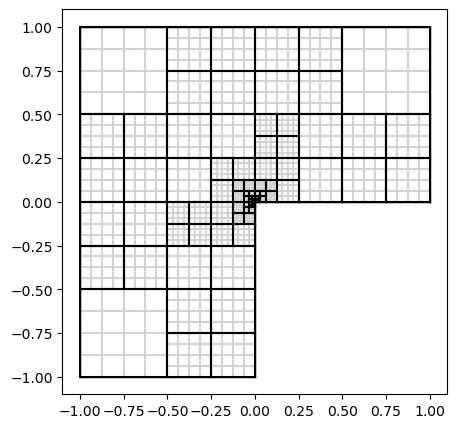

Residual contributions took 0.903862714767456 seconds.
Jump contributions took 1.663257122039795 seconds.
Estimate and Marking took 2.567511796951294 seconds.
Refinement took 0.13710308074951172 seconds.
15


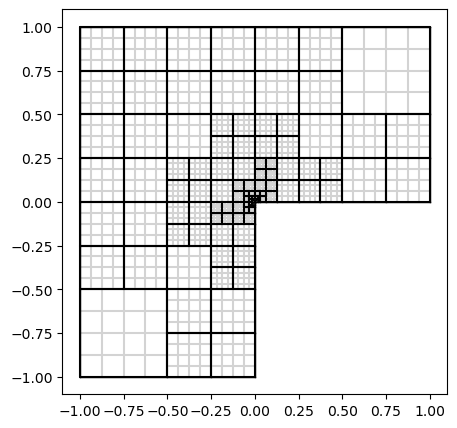

Residual contributions took 1.0667471885681152 seconds.
Jump contributions took 1.9882211685180664 seconds.
Estimate and Marking took 3.0556533336639404 seconds.
Refinement took 0.20731067657470703 seconds.
16


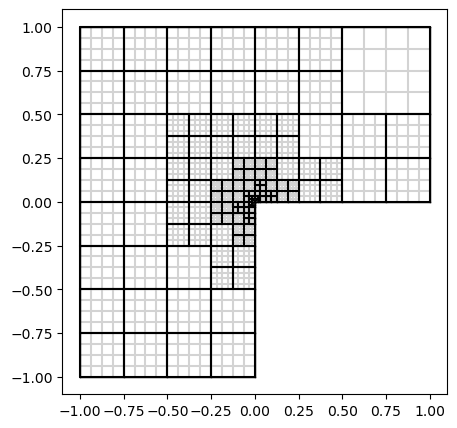

Residual contributions took 1.3057100772857666 seconds.
Jump contributions took 2.3983638286590576 seconds.
Estimate and Marking took 3.7046942710876465 seconds.
Refinement took 0.31812524795532227 seconds.
17


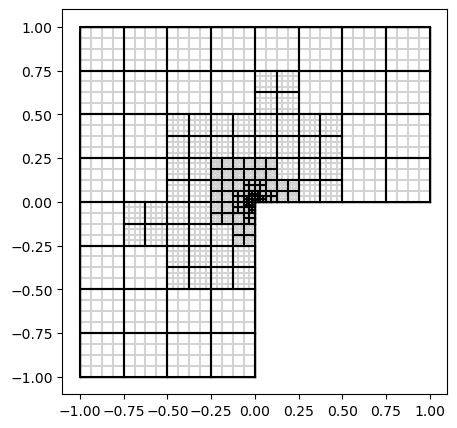

Residual contributions took 1.624647617340088 seconds.
Jump contributions took 2.973209857940674 seconds.
Estimate and Marking took 4.5986785888671875 seconds.
Refinement took 0.5818803310394287 seconds.
18


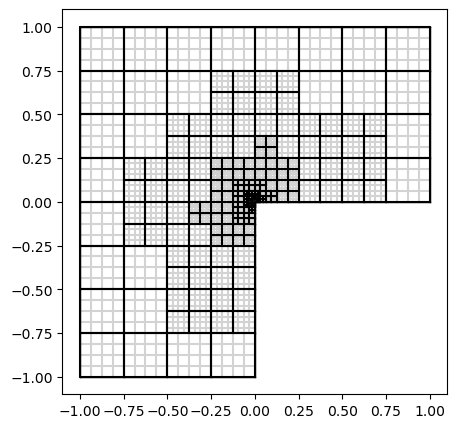

Residual contributions took 2.1213982105255127 seconds.
Jump contributions took 3.856890916824341 seconds.
Estimate and Marking took 5.979077577590942 seconds.
Refinement took 0.9676473140716553 seconds.
19


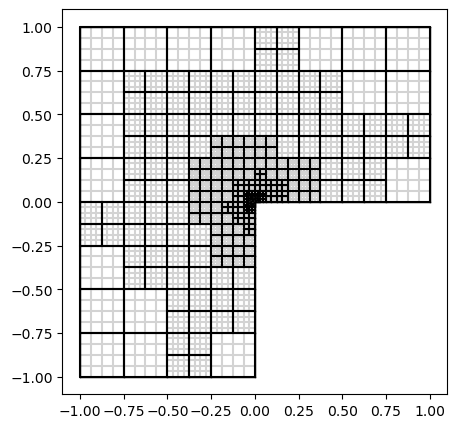

Residual contributions took 2.741839647293091 seconds.
Jump contributions took 4.986856937408447 seconds.
Estimate and Marking took 7.72974157333374 seconds.
Refinement took 1.6078684329986572 seconds.
20


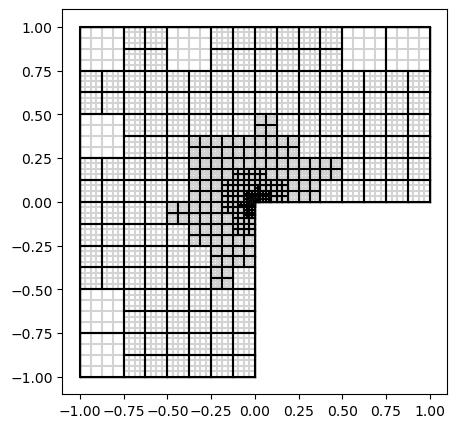

Residual contributions took 3.556366205215454 seconds.
Jump contributions took 6.470020532608032 seconds.
Estimate and Marking took 10.027562618255615 seconds.
Refinement took 2.598475456237793 seconds.
21


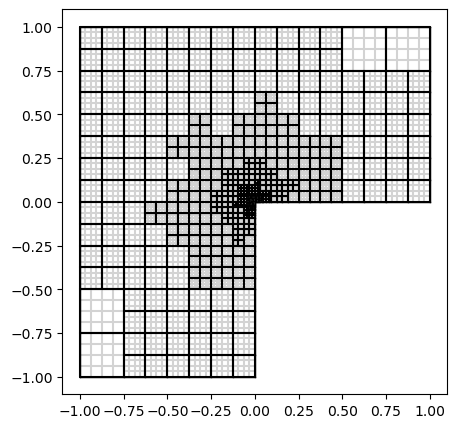

Residual contributions took 4.726567268371582 seconds.
Jump contributions took 8.375214576721191 seconds.
Estimate and Marking took 13.103394746780396 seconds.
Refinement took 4.469080209732056 seconds.
22


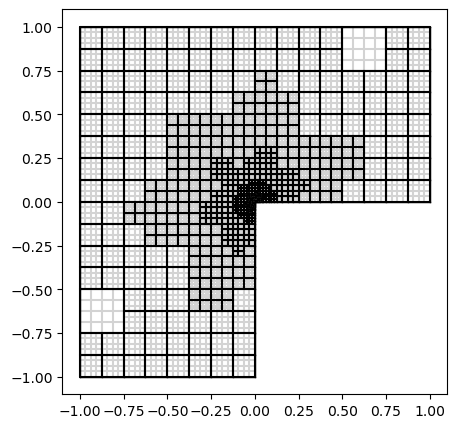

Residual contributions took 6.255486488342285 seconds.
Jump contributions took 11.090640306472778 seconds.
Estimate and Marking took 17.347991943359375 seconds.
Refinement took 8.023787021636963 seconds.
23


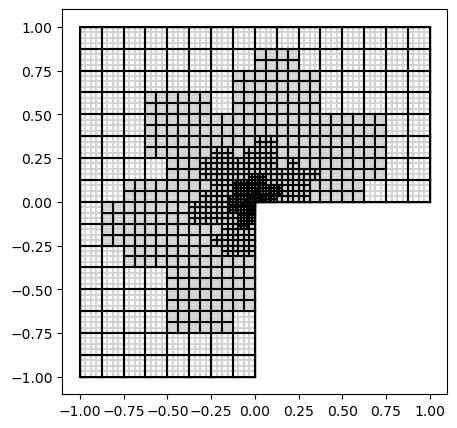

Residual contributions took 8.245490312576294 seconds.
Jump contributions took 14.73601484298706 seconds.
Estimate and Marking took 22.9837749004364 seconds.
Refinement took 14.12289810180664 seconds.
24


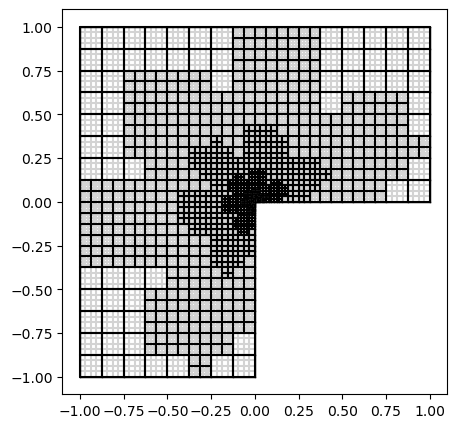

Residual contributions took 11.05515456199646 seconds.
Jump contributions took 19.641169548034668 seconds.
Estimate and Marking took 30.699379920959473 seconds.
Refinement took 24.48350501060486 seconds.
25


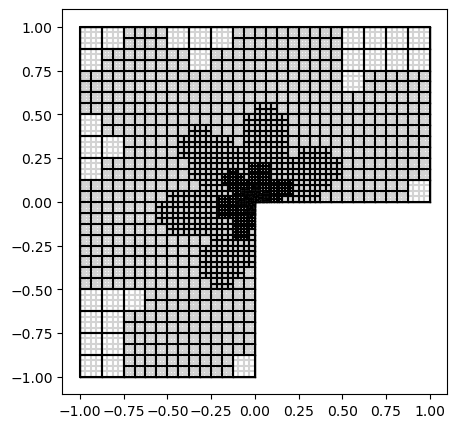

Residual contributions took 14.943838834762573 seconds.
Jump contributions took 26.438002347946167 seconds.
Estimate and Marking took 41.386162996292114 seconds.
Refinement took 42.61651301383972 seconds.
26


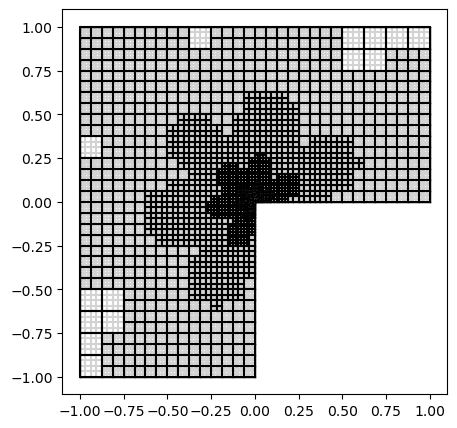

Residual contributions took 19.780842304229736 seconds.
Jump contributions took 34.87536573410034 seconds.
Estimate and Marking took 54.66277098655701 seconds.
Refinement took 80.04133701324463 seconds.
27


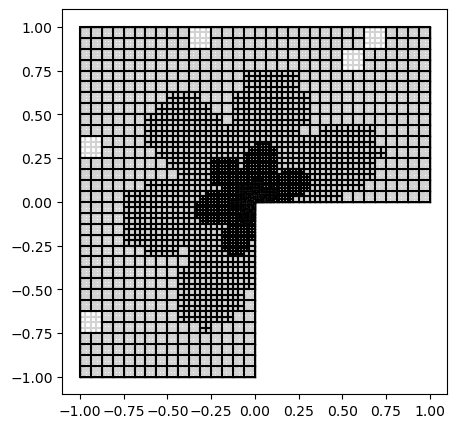

Residual contributions took 26.690053939819336 seconds.
Jump contributions took 47.11157751083374 seconds.
Estimate and Marking took 73.81230044364929 seconds.
Refinement took 147.03708577156067 seconds.
28


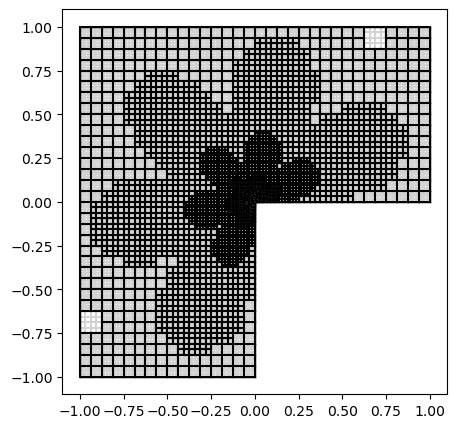

Residual contributions took 36.202367544174194 seconds.
Jump contributions took 64.06218338012695 seconds.
Estimate and Marking took 100.28097486495972 seconds.
Refinement took 260.6815028190613 seconds.
29


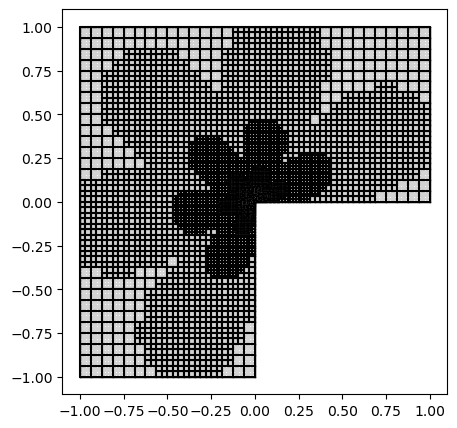

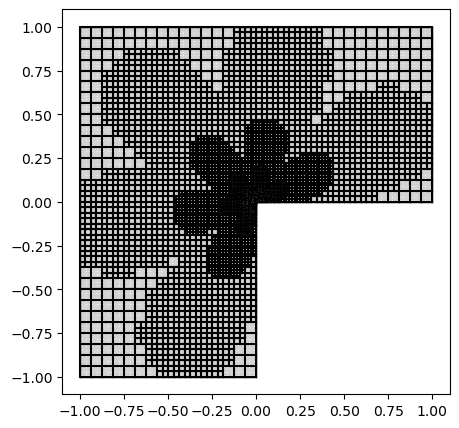

In [11]:
deg=3
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=30, theta=0.9)
M.draw()

In [12]:
np.savetxt('Lp3n4.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

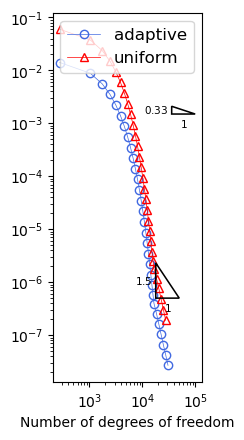

In [21]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,0.5*1e-6),2,1.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.15*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

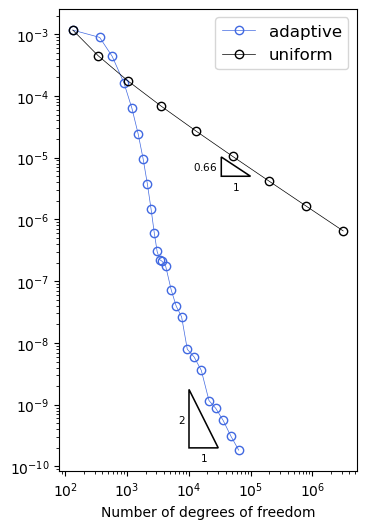

In [240]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.3*1e5,0.2*1e-9),2,slope=2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.05*1e-4),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

0
Refinement took 0.00015592575073242188 seconds.
1
Refinement took 0.00022649765014648438 seconds.
2
Refinement took 0.000171661376953125 seconds.
3
Refinement took 0.00018739700317382812 seconds.
4
Refinement took 0.00022673606872558594 seconds.
5
Refinement took 0.0002605915069580078 seconds.
6
Refinement took 0.00031375885009765625 seconds.
7


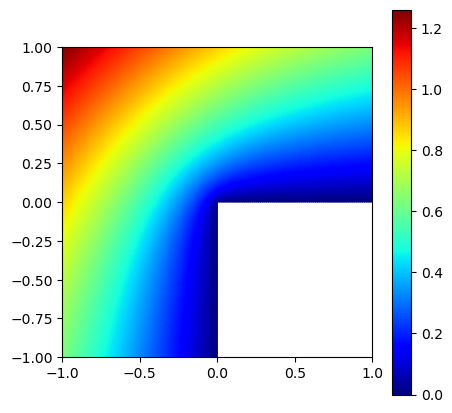

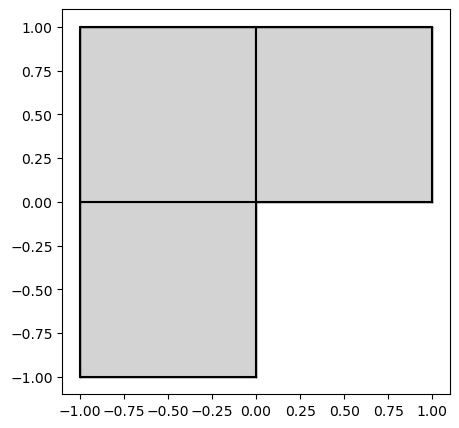

In [13]:
M = Lshape(4,5)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=8, draw=False)
M.draw()

0


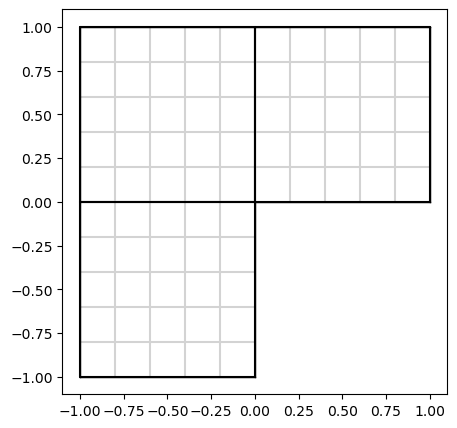

Residual contributions took 0.019728899002075195 seconds.
Jump contributions took 0.010332584381103516 seconds.
Estimate and Marking took 0.03021860122680664 seconds.
Refinement took 0.008764505386352539 seconds.
1


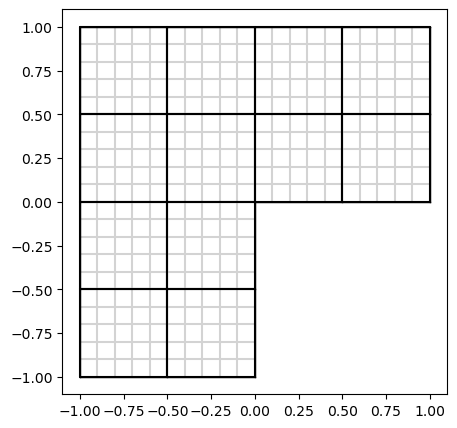

Residual contributions took 0.07452797889709473 seconds.
Jump contributions took 0.08965229988098145 seconds.
Estimate and Marking took 0.16437911987304688 seconds.
Refinement took 0.010378122329711914 seconds.
2


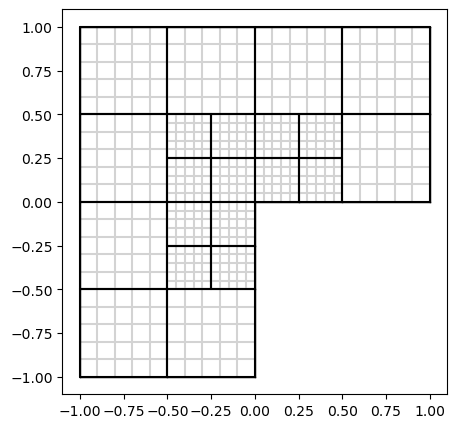

Residual contributions took 0.12473845481872559 seconds.
Jump contributions took 0.18383455276489258 seconds.
Estimate and Marking took 0.30875086784362793 seconds.
Refinement took 0.012566089630126953 seconds.
3


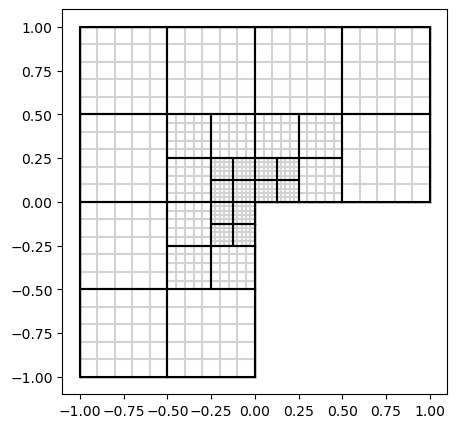

Residual contributions took 0.18079304695129395 seconds.
Jump contributions took 0.29755282402038574 seconds.
Estimate and Marking took 0.4785780906677246 seconds.
Refinement took 0.015151739120483398 seconds.
4


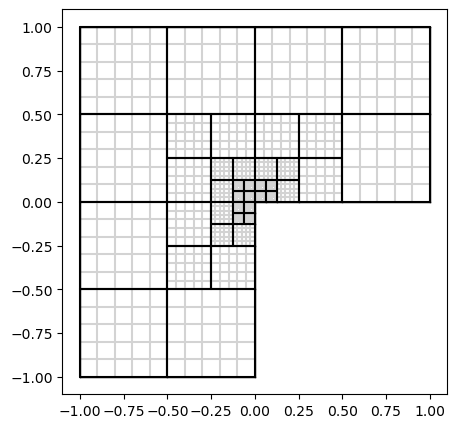

Residual contributions took 0.23184490203857422 seconds.
Jump contributions took 0.4035062789916992 seconds.
Estimate and Marking took 0.635615348815918 seconds.
Refinement took 0.017385482788085938 seconds.
5


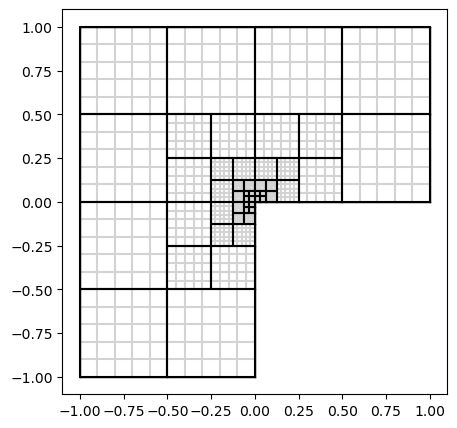

Residual contributions took 0.3010826110839844 seconds.
Jump contributions took 0.5220270156860352 seconds.
Estimate and Marking took 0.8233652114868164 seconds.
Refinement took 0.019277334213256836 seconds.
6


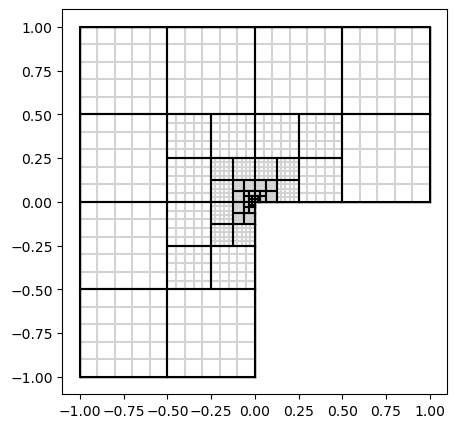

Residual contributions took 0.4110686779022217 seconds.
Jump contributions took 0.6156938076019287 seconds.
Estimate and Marking took 1.0270333290100098 seconds.
Refinement took 0.020519256591796875 seconds.
7


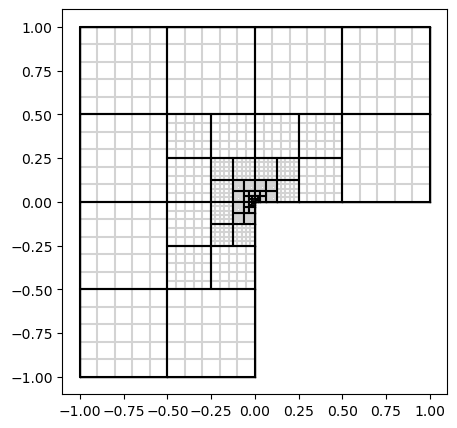

Residual contributions took 0.3966381549835205 seconds.
Jump contributions took 0.7513704299926758 seconds.
Estimate and Marking took 1.148444652557373 seconds.
Refinement took 0.022870779037475586 seconds.
8


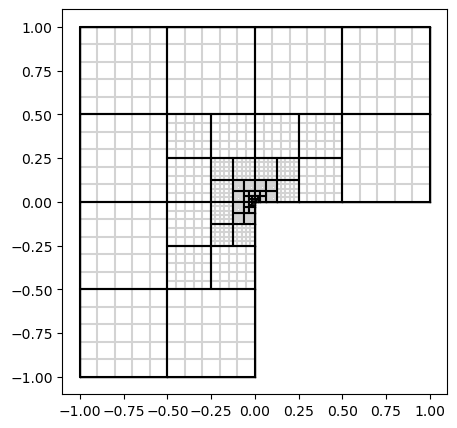

Residual contributions took 0.4540438652038574 seconds.
Jump contributions took 0.8401815891265869 seconds.
Estimate and Marking took 1.2945311069488525 seconds.
Refinement took 0.02456378936767578 seconds.
9


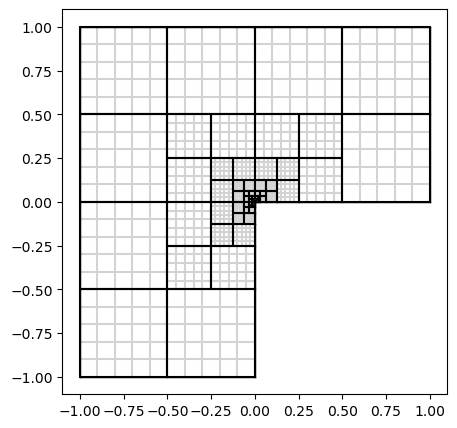

Residual contributions took 0.5235047340393066 seconds.
Jump contributions took 0.9620256423950195 seconds.
Estimate and Marking took 1.4861295223236084 seconds.
Refinement took 0.027008056640625 seconds.
10


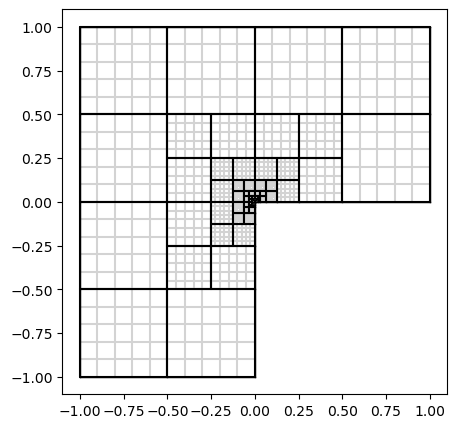

Residual contributions took 0.5925054550170898 seconds.
Jump contributions took 1.050987720489502 seconds.
Estimate and Marking took 1.6437737941741943 seconds.
Refinement took 0.028662443161010742 seconds.
11


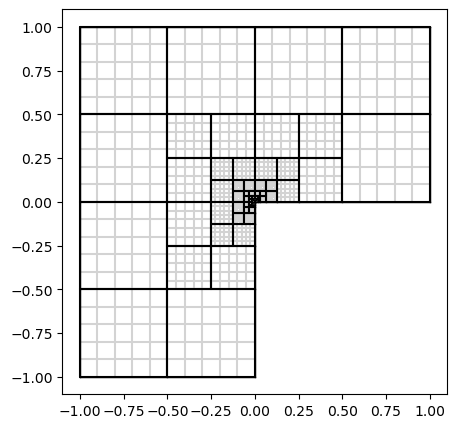

Residual contributions took 0.6135647296905518 seconds.
Jump contributions took 1.1563239097595215 seconds.
Estimate and Marking took 1.7701964378356934 seconds.
Refinement took 0.030177831649780273 seconds.
12


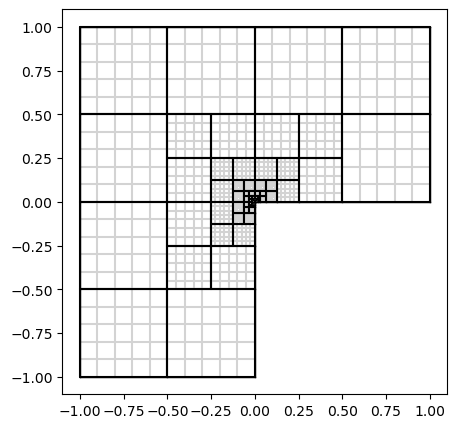

Residual contributions took 0.6631033420562744 seconds.
Jump contributions took 1.2570350170135498 seconds.
Estimate and Marking took 1.9207186698913574 seconds.
Refinement took 0.031833648681640625 seconds.
13


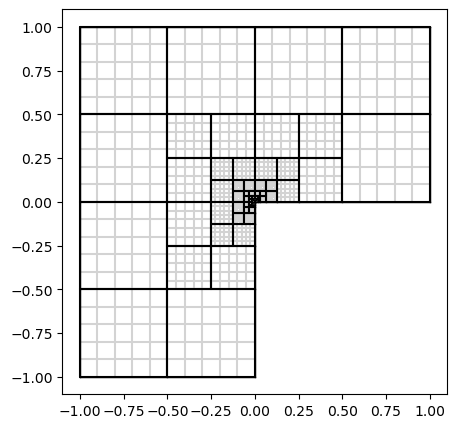

Residual contributions took 0.7202982902526855 seconds.
Jump contributions took 1.3706560134887695 seconds.
Estimate and Marking took 2.091251850128174 seconds.
Refinement took 0.034098148345947266 seconds.
14


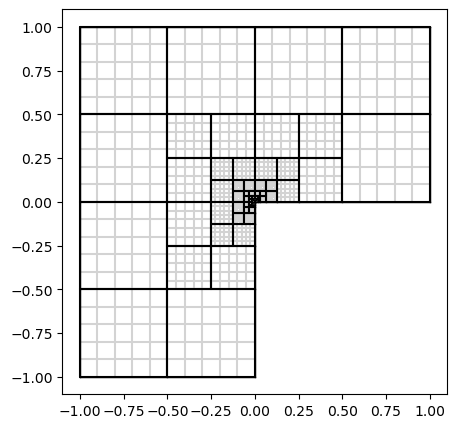

Residual contributions took 0.85894775390625 seconds.
Jump contributions took 1.57352614402771 seconds.
Estimate and Marking took 2.432807683944702 seconds.
Refinement took 0.03645730018615723 seconds.
15


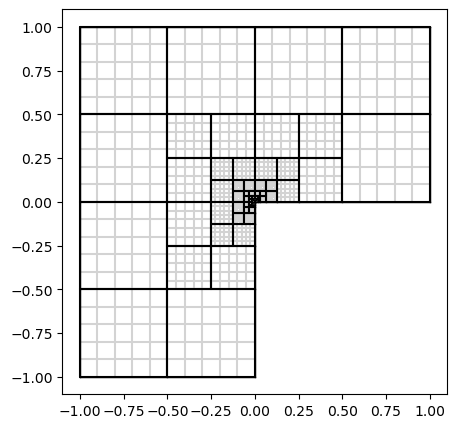

Residual contributions took 0.8699970245361328 seconds.
Jump contributions took 1.6464693546295166 seconds.
Estimate and Marking took 2.5167980194091797 seconds.
Refinement took 0.03796720504760742 seconds.
16


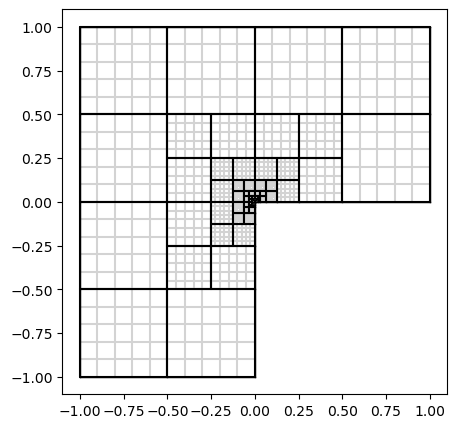

Residual contributions took 0.9060466289520264 seconds.
Jump contributions took 1.7265658378601074 seconds.
Estimate and Marking took 2.6329505443573 seconds.
Refinement took 0.04010319709777832 seconds.
17


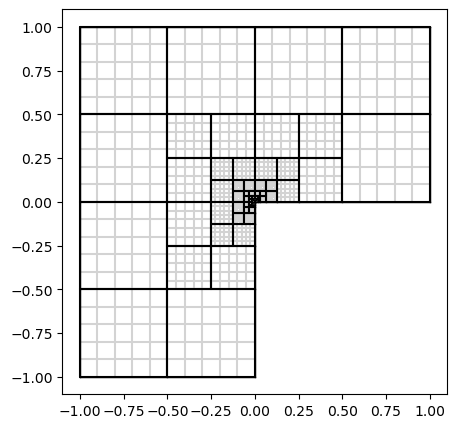

Residual contributions took 0.9658839702606201 seconds.
Jump contributions took 1.797412395477295 seconds.
Estimate and Marking took 2.7636303901672363 seconds.
Refinement took 0.041944026947021484 seconds.
18


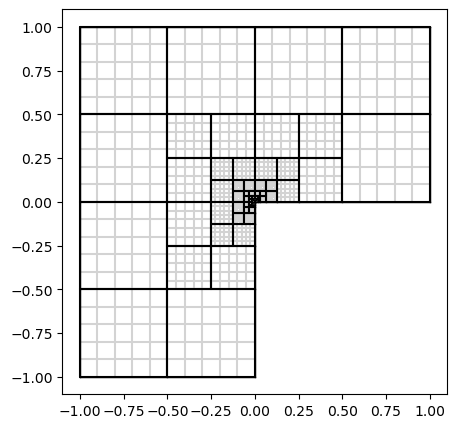

Residual contributions took 1.0123333930969238 seconds.
Jump contributions took 1.9290881156921387 seconds.
Estimate and Marking took 2.9417850971221924 seconds.
Refinement took 0.04648637771606445 seconds.
19


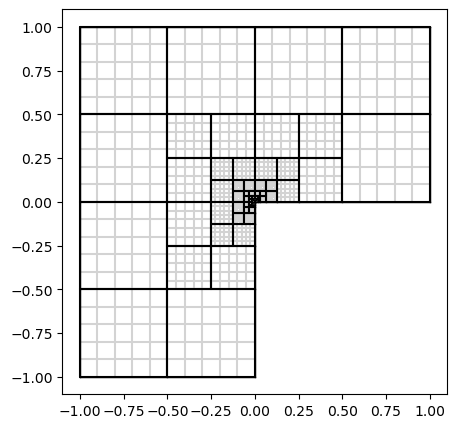

Residual contributions took 1.0532402992248535 seconds.
Jump contributions took 2.0024471282958984 seconds.
Estimate and Marking took 3.0560302734375 seconds.
Refinement took 0.04555010795593262 seconds.
20


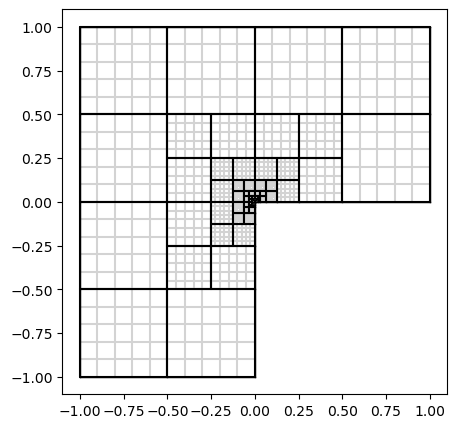

Residual contributions took 1.097853660583496 seconds.
Jump contributions took 2.1114189624786377 seconds.
Estimate and Marking took 3.2098448276519775 seconds.
Refinement took 0.0473484992980957 seconds.
21


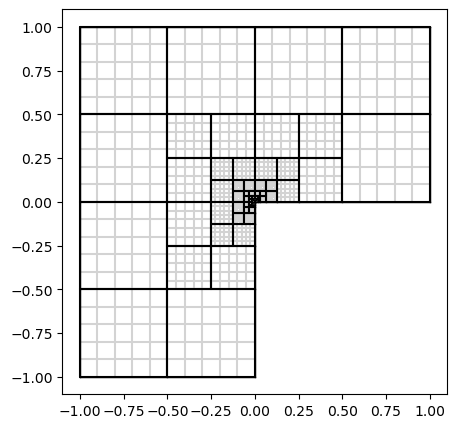

Residual contributions took 1.1688964366912842 seconds.
Jump contributions took 2.2325947284698486 seconds.
Estimate and Marking took 3.4020493030548096 seconds.
Refinement took 0.051221370697021484 seconds.
22


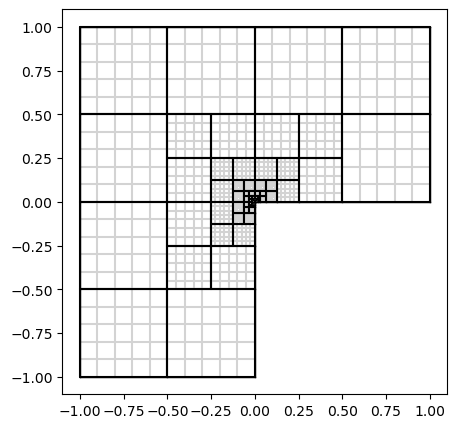

Residual contributions took 1.2252459526062012 seconds.
Jump contributions took 2.324493408203125 seconds.
Estimate and Marking took 3.550124168395996 seconds.
Refinement took 0.1408843994140625 seconds.
23


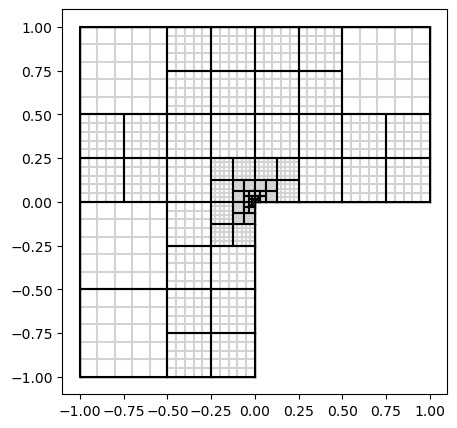

Residual contributions took 1.3915495872497559 seconds.
Jump contributions took 2.5775697231292725 seconds.
Estimate and Marking took 3.9698376655578613 seconds.
Refinement took 0.1721799373626709 seconds.
24


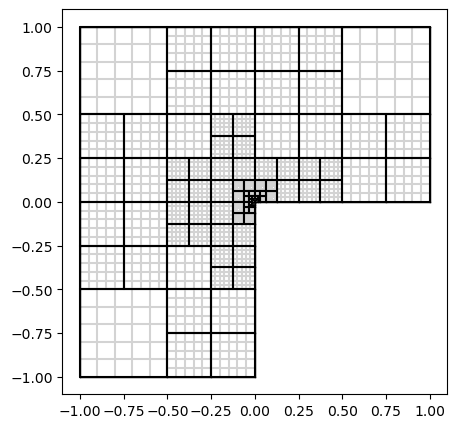

Residual contributions took 1.5554330348968506 seconds.
Jump contributions took 2.868921995162964 seconds.
Estimate and Marking took 4.425037622451782 seconds.
Refinement took 0.1916210651397705 seconds.
25


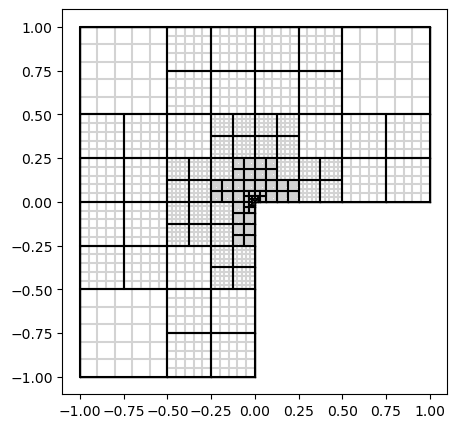

Residual contributions took 1.7178668975830078 seconds.
Jump contributions took 3.1923530101776123 seconds.
Estimate and Marking took 4.910929203033447 seconds.
Refinement took 0.2508111000061035 seconds.
26


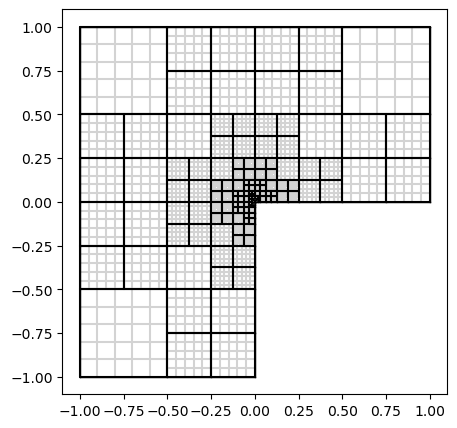

Residual contributions took 1.9148809909820557 seconds.
Jump contributions took 3.5560474395751953 seconds.
Estimate and Marking took 5.47166109085083 seconds.
Refinement took 0.32546305656433105 seconds.
27


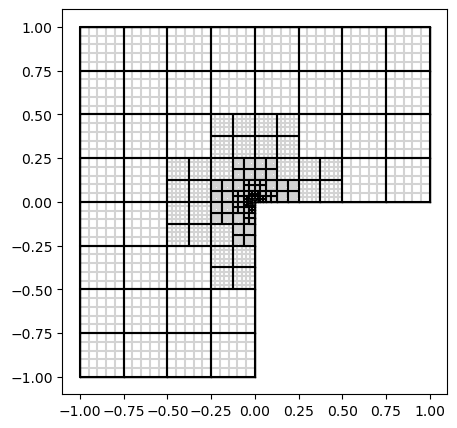

Residual contributions took 2.1577820777893066 seconds.
Jump contributions took 3.9712131023406982 seconds.
Estimate and Marking took 6.129792213439941 seconds.
Refinement took 0.387218713760376 seconds.
28


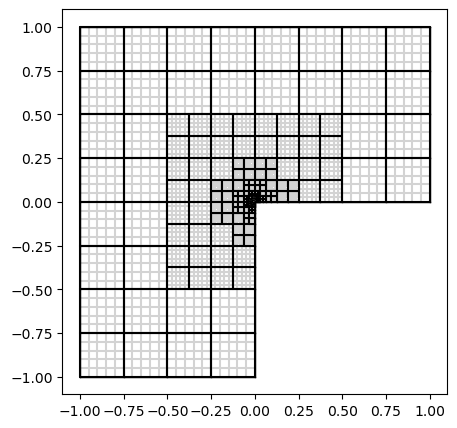

Residual contributions took 2.449364423751831 seconds.
Jump contributions took 4.458921670913696 seconds.
Estimate and Marking took 6.9092185497283936 seconds.
Refinement took 0.577211856842041 seconds.
29


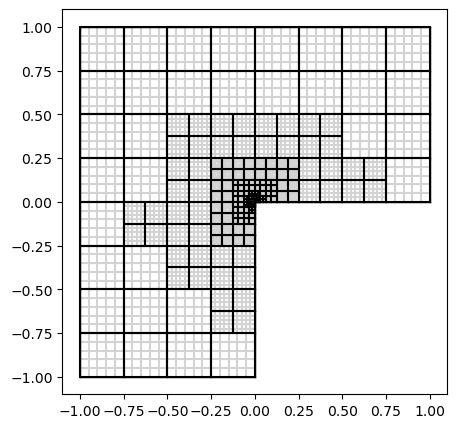

Residual contributions took 2.7567384243011475 seconds.
Jump contributions took 5.075944900512695 seconds.
Estimate and Marking took 7.83359956741333 seconds.
Refinement took 0.8219995498657227 seconds.
30


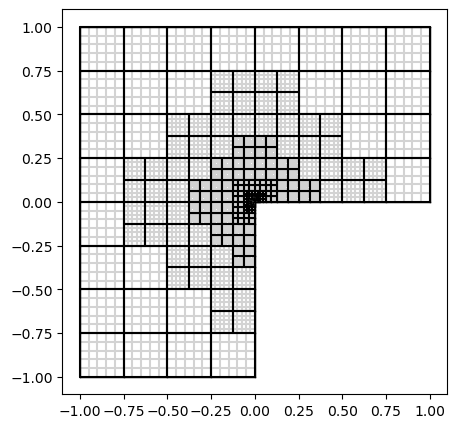

Residual contributions took 3.2257680892944336 seconds.
Jump contributions took 6.061333894729614 seconds.
Estimate and Marking took 9.288151741027832 seconds.
Refinement took 1.1295256614685059 seconds.
31


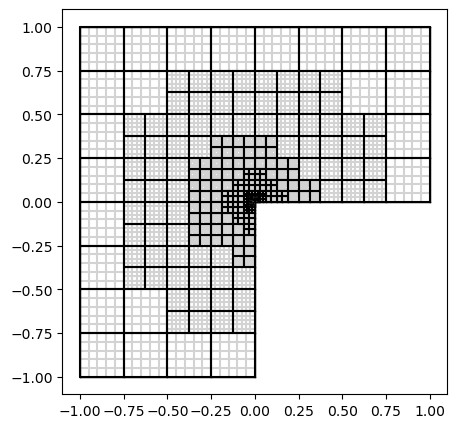

Residual contributions took 3.771669864654541 seconds.
Jump contributions took 6.8799355030059814 seconds.
Estimate and Marking took 10.652667999267578 seconds.
Refinement took 1.5920815467834473 seconds.
32


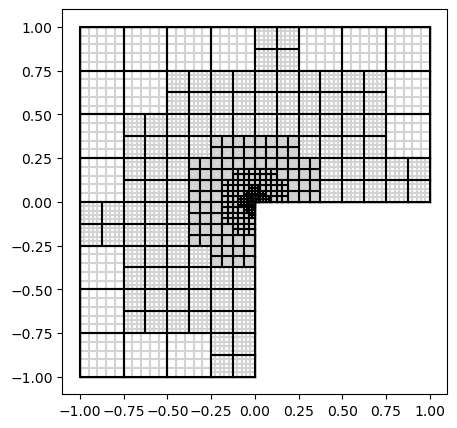

Residual contributions took 4.412839651107788 seconds.
Jump contributions took 7.983698844909668 seconds.
Estimate and Marking took 12.39775276184082 seconds.
Refinement took 2.287811040878296 seconds.
33


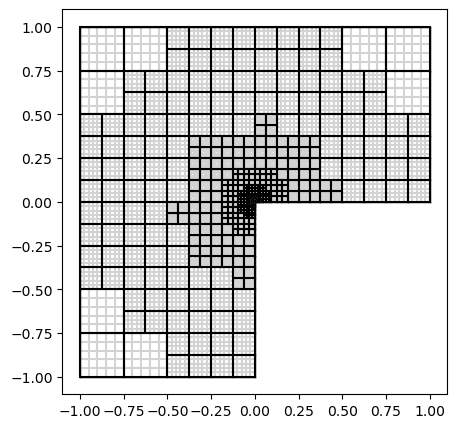

Residual contributions took 5.249958753585815 seconds.
Jump contributions took 9.481707096099854 seconds.
Estimate and Marking took 14.733015537261963 seconds.
Refinement took 2.8066632747650146 seconds.
34


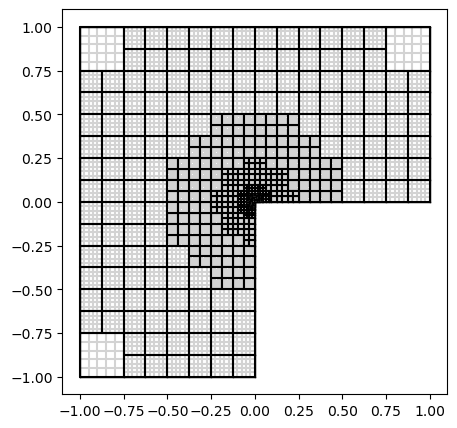

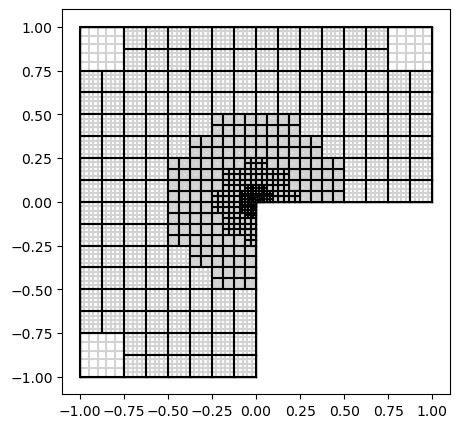

In [16]:
M = Lshape(4,5)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=35)
M.draw()

In [17]:
np.savetxt('Lp4n5.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

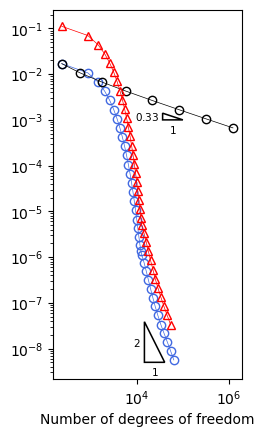

In [18]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.4*1e5,0.5*1e-8),2,2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.1*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

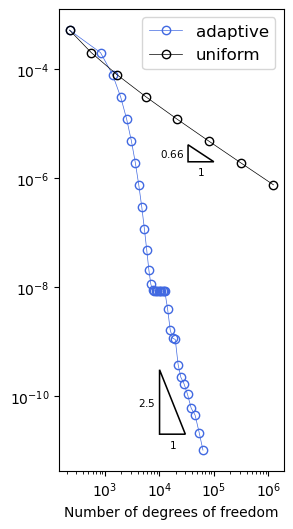

In [262]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.3*1e5,0.2*1e-10),2,slope=2.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.2*1e-5),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()